##PROJECT METODE REKAYASA KOMPUTASIONAL
#####YUNIFAR SETYO RAHARJO_552357
#####ANNISA FAJRISIMA LISTYASARI_552594


Project ini dibuat untuk memenuhi tugas mata kuliah Metode Rekayasa Komputasional Program Magister Teknik Fisika
Project ini dikerjakan secara berkelompok oleh kelompok 4.

Menggunakan data Wind Turbine dengan Link Kaggle:
https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

Data ini berisikan Data Wind Turbine selama 1 Tahun di Turkey.

Data diambil setiap 10 menit melalui SCADA System.

Data dapat digunakan sebagai baseline untuk feasibility study dalam pembangunan PLTB di suatu Lokasi. Machine Learning digunakan dalam memprediksi daya aktual yang akan dihasilkan di suatu lokasi apabila terdapat data kecepatan angin dan data teoritical power (kWh) yang dapat dihitung secara matematis. Feasibility Study dalam pembangunan PLTB sangat membantu baik dari segi teknis maupun ekonomi untuk mengetahui suatu lokasi yang memiliki potensi untuk dibangun PLTB.


A. Loading Python Libraries dan Meng-Upload Dataset

In [ ]:
#Upload Files Data Wind Turbine
from google.colab import files

Wind_Dataset = files.upload()

Saving Wind Turbine Dataset.csv to Wind Turbine Dataset.csv


In [4]:
#import Library yang akan digunakan
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

B. Input Data Frame

In [ ]:
#Membaca data Wind Turbine
df_wind = pd.read_csv('Wind Turbine Dataset.csv')
df_wind.head(10)

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   
5  01 01 2018 00:50           402.391998          5.604052   
6  01 01 2018 01:00           447.605713          5.793008   
7  01 01 2018 01:10           387.242188          5.306050   
8  01 01 2018 01:20           463.651215          5.584629   
9  01 01 2018 01:30           439.725708          5.523228   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
5                     499.436385          264.578613  
6                     557.372363          266.163605  
7                     414.898179          257.949493  
8                     493.677652          253.480698  
9                     475.706783          258.723785

In [ ]:
#Konversi Tanggal dan Cek Informasi Dataset
df_wind["Date/Time"] = pd.to_datetime(df_wind["Date/Time"], format="%d %m %Y %H:%M")

# Ekstraksi fitur waktu
df_wind["Year"] = df_wind["Date/Time"].dt.year
df_wind["Month"] = df_wind["Date/Time"].dt.month
df_wind["Day"] = df_wind["Date/Time"].dt.day
df_wind["Hour"] = df_wind["Date/Time"].dt.hour
df_wind["Minute"] = df_wind["Date/Time"].dt.minute

# Drop kolom Date/Time
df_wind.drop(columns=["Date/Time"], inplace=True)

print(df_wind.info())
print(df_wind.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   Year                           50530 non-null  int32  
 5   Month                          50530 non-null  int32  
 6   Day                            50530 non-null  int32  
 7   Hour                           50530 non-null  int32  
 8   Minute                         50530 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 2.5 MB
None
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307

In [ ]:
#Display Structure Data Frame
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   Year                           50530 non-null  int32  
 5   Month                          50530 non-null  int32  
 6   Day                            50530 non-null  int32  
 7   Hour                           50530 non-null  int32  
 8   Minute                         50530 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 2.5 MB


In [ ]:
# Cek jumlah nilai nol di setiap kolom
zero_values = (df_wind == 0).sum()
zero_values

LV ActivePower (kW)              10781
Wind Speed (m/s)                    10
Theoretical_Power_Curve (KWh)     7749
Wind Direction (°)                  75
Year                                 0
Month                                0
Day                                  0
Hour                              2112
Minute                            8422
dtype: int64

###Cleaning Dataset

In [ ]:
#Menghilangkan beberapa data yang tidak digunakan dalam analisis karena berpotensi mengurangi akurasi model

# Hapus data di mana Wind Speed = 0 atau Wind Direction = 0
df_wind = df_wind[(df_wind["Wind Speed (m/s)"] > 0) & (df_wind["Wind Direction (°)"] > 0)]

# Hapus data dengan Active Power = 0 hanya jika Wind Speed > 3 m/s (menghindari data saat turbin mati)
df_wind = df_wind[~((df_wind["Wind Speed (m/s)"] > 3) & (df_wind["LV ActivePower (kW)"] == 0))]

# Hapus data duplikat
df_wind = df_wind.drop_duplicates()

#menampilkan data
df_wind

LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
0               380.047791          5.311336                     416.328908   
1               453.769196          5.672167                     519.917511   
2               306.376587          5.216037                     390.900016   
3               419.645905          5.659674                     516.127569   
4               380.650696          5.577941                     491.702972   
...                    ...               ...                            ...   
50525          2963.980957         11.404030                    3397.190793   
50526          1684.353027          7.332648                    1173.055771   
50527          2201.106934          8.435358                    1788.284755   
50528          2515.694092          9.421366                    2418.382503   
50529          2820.466064          9.979332                    2779.184096   

       Wind Direction (°)  Year  Month  Day  Hour  Minute  
0              259.994904  2018      1    1     0       0  
1              268.641113  2018      1    1     0      10  
2              272.564789  2018      1    1     0      20  
3              271.258087  2018      1    1     0      30  
4              265.674286  2018      1    1     0      40  
...                   ...   ...    ...  ...   ...     ...  
50525           80.502724  2018     12   31    23      10  
50526           84.062599  2018     12   31    23      20  
50527           84.742500  2018     12   31    23      30  
50528           84.297913  2018     12   31    23      40  
50529           82.274620  2018     12   31    23      50  

[47003 rows x 9 columns]

C. Visualisasi Data

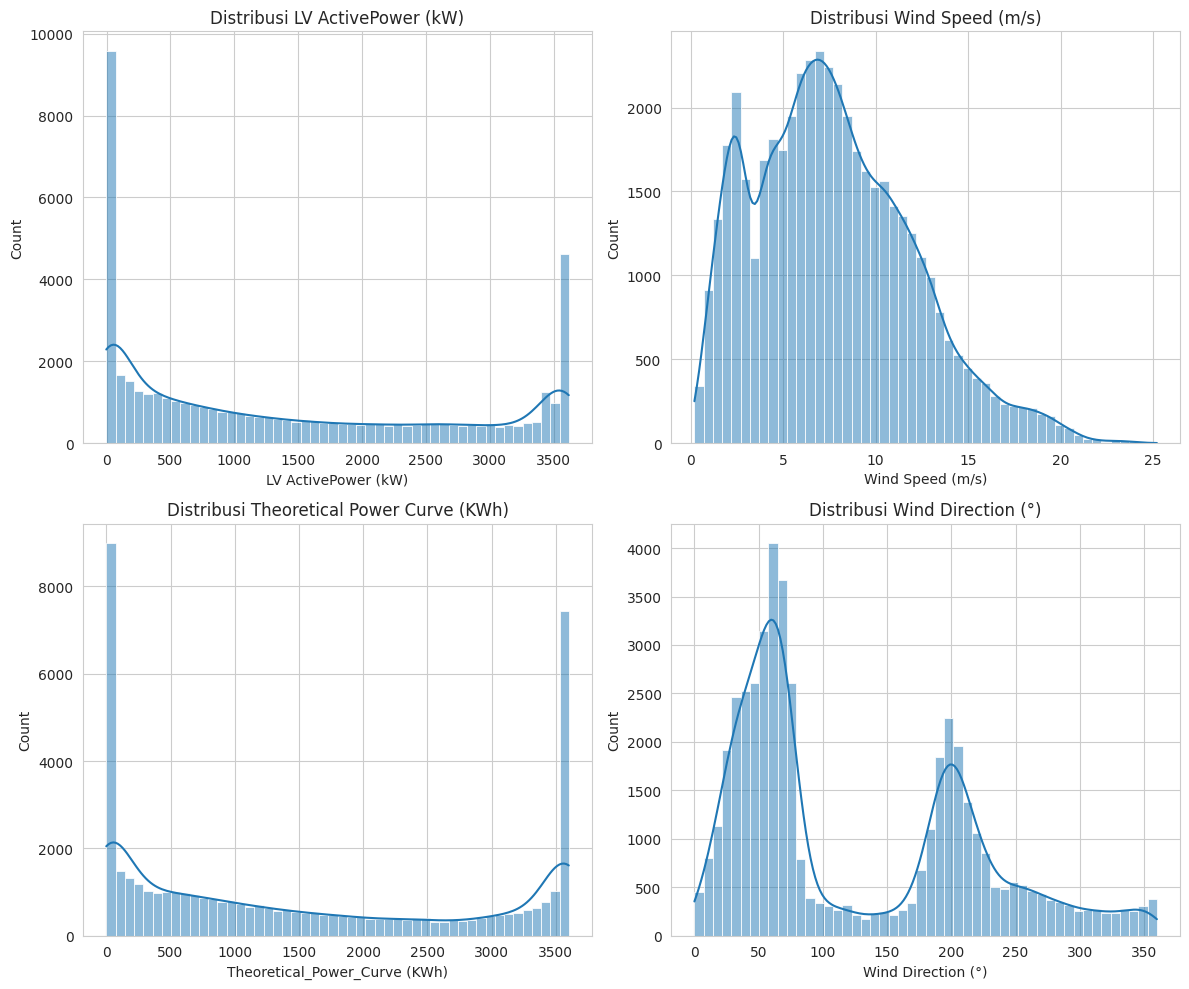

In [ ]:
# Set style seaborn
sns.set_style("whitegrid")

# Plot distribusi fitur numerik
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df_wind["LV ActivePower (kW)"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribusi LV ActivePower (kW)")

sns.histplot(df_wind["Wind Speed (m/s)"], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribusi Wind Speed (m/s)")

sns.histplot(df_wind["Theoretical_Power_Curve (KWh)"], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribusi Theoretical Power Curve (KWh)")

sns.histplot(df_wind["Wind Direction (°)"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribusi Wind Direction (°)")

plt.tight_layout()
plt.show()

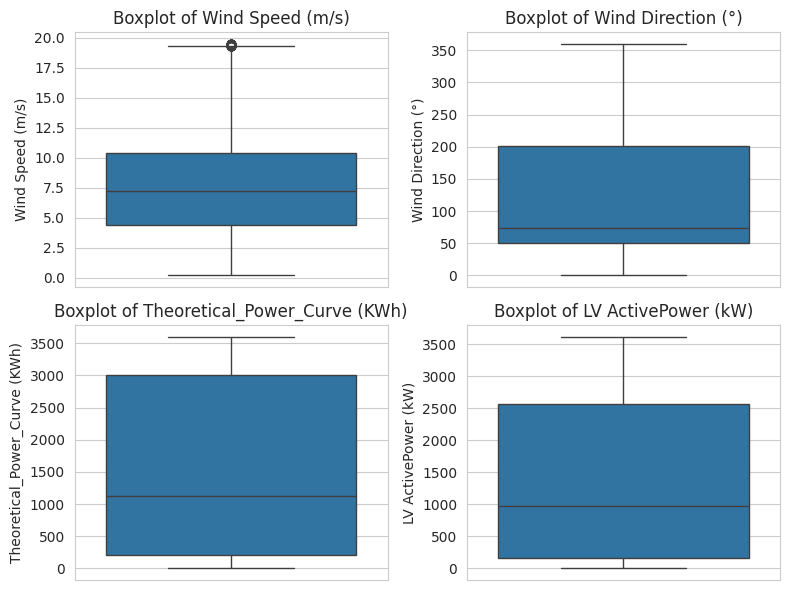

In [ ]:
# Visualizing outliers using box plot, analisis statistik
plt.figure(figsize=(12, 8))
for i, col in enumerate(["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)","LV ActivePower (kW)"]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df_wind[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Menangani outlier dengan IQR
Q1 = df_wind.quantile(0.25)
Q3 = df_wind.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_wind = df_wind[~((df_wind < lower_bound) | (df_wind > upper_bound)).any(axis=1)]
df_wind

LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
0               380.047791          5.311336                     416.328908   
1               453.769196          5.672167                     519.917511   
2               306.376587          5.216037                     390.900016   
3               419.645905          5.659674                     516.127569   
4               380.650696          5.577941                     491.702972   
...                    ...               ...                            ...   
50525          2963.980957         11.404030                    3397.190793   
50526          1684.353027          7.332648                    1173.055771   
50527          2201.106934          8.435358                    1788.284755   
50528          2515.694092          9.421366                    2418.382503   
50529          2820.466064          9.979332                    2779.184096   

       Wind Direction (°)  Year  Month  Day  Hour  Minute  
0              259.994904  2018      1    1     0       0  
1              268.641113  2018      1    1     0      10  
2              272.564789  2018      1    1     0      20  
3              271.258087  2018      1    1     0      30  
4              265.674286  2018      1    1     0      40  
...                   ...   ...    ...  ...   ...     ...  
50525           80.502724  2018     12   31    23      10  
50526           84.062599  2018     12   31    23      20  
50527           84.742500  2018     12   31    23      30  
50528           84.297913  2018     12   31    23      40  
50529           82.274620  2018     12   31    23      50  

[46595 rows x 9 columns]

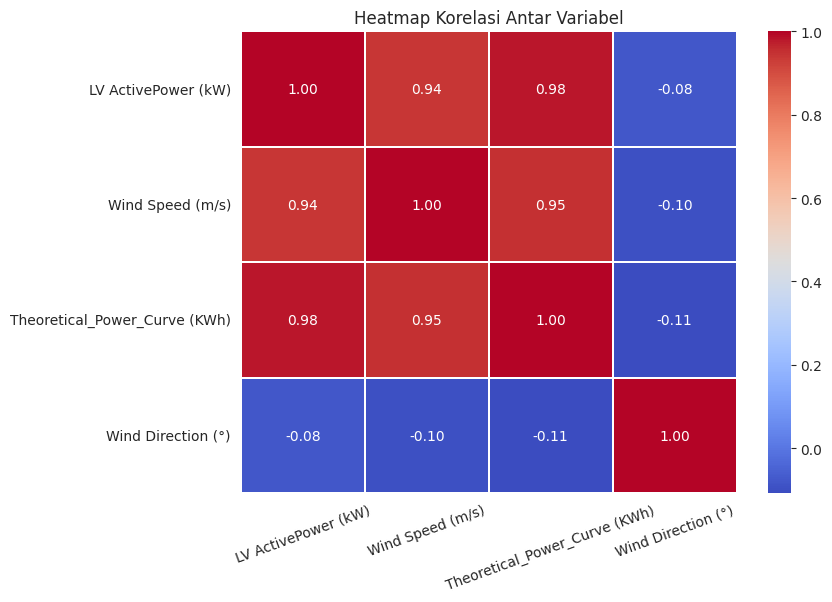

In [ ]:
#Membuat Hubungan Korelasi Antar Variabel Berbasis Heatmap Untuk Data Numeric
numeric_df = df_wind.drop(columns=["Year", "Month", "Day", "Hour", "Minute"])
numeric_df_ = numeric_df.select_dtypes(include=[np.number]) #seluruh data numeric
if numeric_df_.shape[1] > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.2)
    plt.xticks(rotation=20)
    plt.title("Heatmap Korelasi Antar Variabel")
    plt.show()

<Figure size 1000x1000 with 0 Axes>

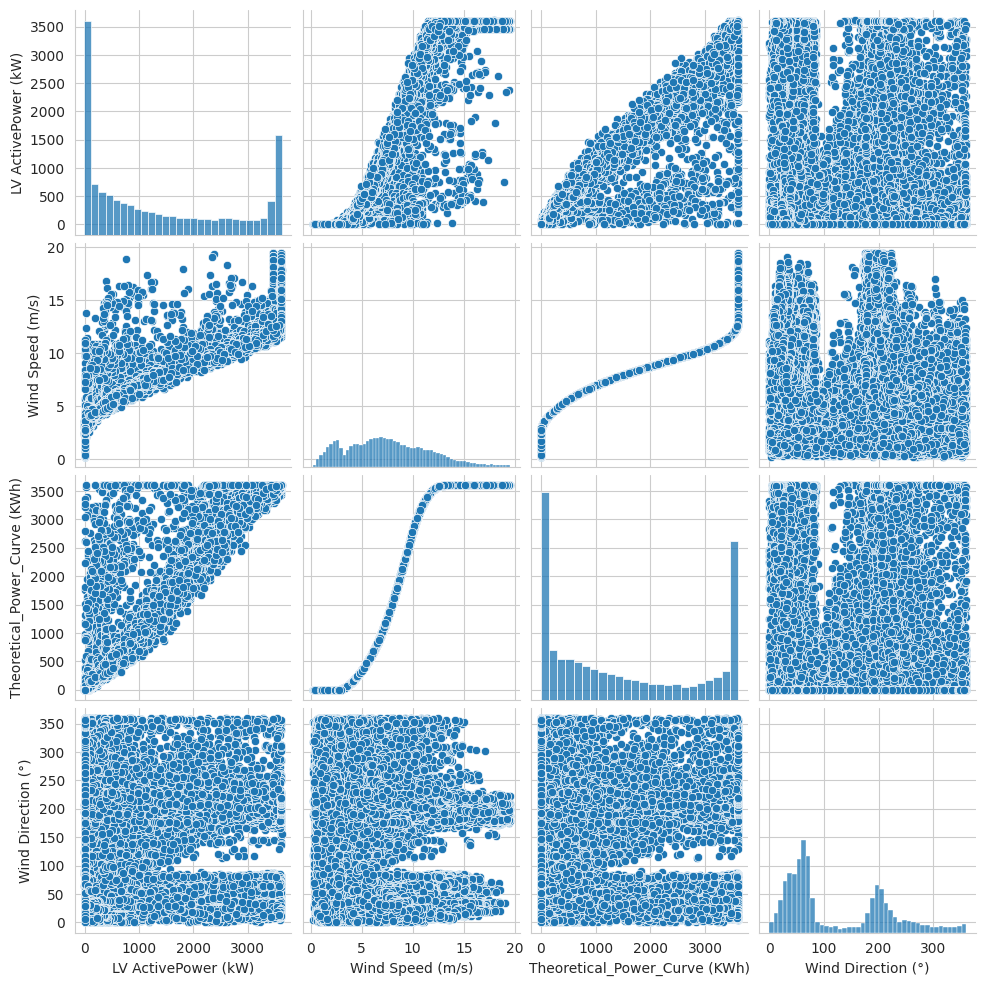

In [ ]:
#Melihat hubungan antara variabel data yang ada menggunakan PairPlot
plt.figure(figsize = (10,10))
sns.pairplot(df_wind.drop(columns=["Year", "Month", "Day", "Hour", "Minute"]))
plt.show()

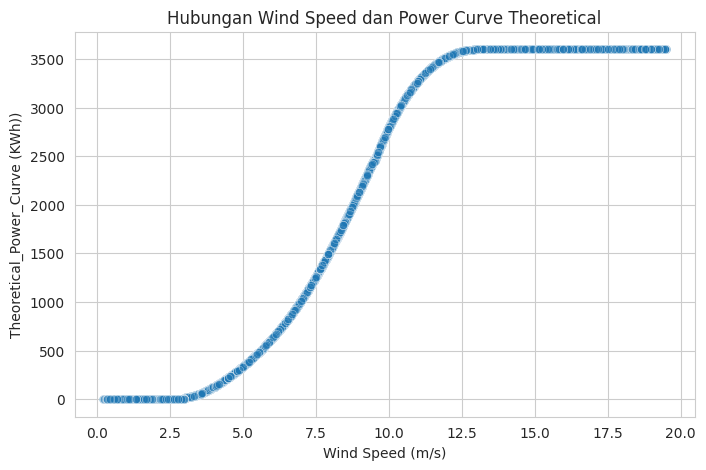

In [ ]:
#Scatter Plot Wind Speed vs Power
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_wind["Wind Speed (m/s)"], y=df_wind["Theoretical_Power_Curve (KWh)"], alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Theoretical_Power_Curve (KWh))")
plt.title("Hubungan Wind Speed dan Power Curve Theoretical")
plt.show()

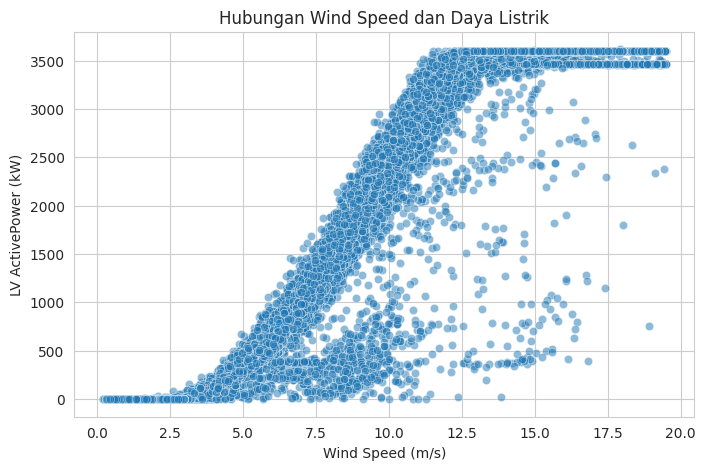

In [ ]:
#Scatter Plot Wind Speed vs Power
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_wind["Wind Speed (m/s)"], y=df_wind["LV ActivePower (kW)"], alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("LV ActivePower (kW)")
plt.title("Hubungan Wind Speed dan Daya Listrik")
plt.show()

Persiapan dataset ini menyatakan bahwa data tidak memiliki NaN value. Hal ini dapat dilihat pada heatmap atau pairplot diatas, sehingga dataset ini siap diolah atau dianalisis.

##MACHINE LEARNING
Pada hal ini, kami menggunakan metode Linear Regression yang diadopsi dari library Skicit-Learn.
Kami membandingkan hasil dari Linear Regression sebelum dan sesudah menggunakan Normalisasi (Standard Scaler). Stadandard Scaler adalah Algoritme cepat dan khusus untuk penskalaan data. Algoritme ini menghitung nilai rata-rata dan simpangan baku dari kumpulan data dan menormalkannya dengan mengurangi nilai rata-rata dan membaginya dengan simpangan baku.

###DATA PREPARATION

In [ ]:
#Data untuk Machine Learning, features selection
features = ["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)","Year","Month","Day","Hour","Minute"] #Sebagai Inputan
target = "LV ActivePower (kW)" #Sebagai Prediksi
X = df_wind[features]
y = df_wind[target]

In [ ]:
#Splitting Data Train-Test dengan Test_size 20%
#Test Size 20% menggunakan data 20% data set untuk test, sedangkan 80%datanya digunakan sebagai training Modelnya
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###MODEL MACHINE LEARNING YANG DIGUNAKAN

In [ ]:
#Menggunakan normalisasi
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [ ]:
# Transformasi Power untuk mengatasi distribusi skewed
power_transformer = PowerTransformer()
X_train = power_transformer.fit_transform(X_train)
X_test = power_transformer.transform(X_test)

In [ ]:
#Training Linear Regression Model
LR = LinearRegression() #
LR.fit(X_train, y_train)

# Hyperparameter tuning Untuk Metode Random Forest Regression dan Gradient Bosting Regression
"Hyperparameter Tuning ini digunakan untuk membuat model yang memiliki best prediction"
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [2, 4]}
param_grid_gb = {'n_estimators': [50, 80], 'learning_rate': [0.1, 0.01], 'max_depth': [5, 20]}
param_grid_ada = {'n_estimators': [50,80], 'learning_rate': [0.1, 0.01]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf,cv=5, scoring="r2", n_jobs=-1)
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring="r2", n_jobs=-1)
ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid_ada,cv=5, scoring="r2", n_jobs=-1)
#Training Machine Learning Untuk Random Forest dan Gradient Boosting Regression
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
ada_grid.fit(X_train, y_train)

#Memilih Model yang paling Bagus
best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_
best_ada = ada_grid.best_estimator_

#Membuat definisi baru
RF = best_rf
RGB = best_gb
ADA = best_ada

In [ ]:
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best parameters for Gradient Boosting:", gb_grid.best_params_)
print("Best parameters for AdaBoost:", ada_grid.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)

    return {"Model": model.__class__.__name__, "MAE": mae, "MSE": mse,"RMSE": rmse, "R2": r2, "Cross Validation Score":mean_cv_score}, y_pred

In [ ]:
lin_results, y_pred_lin = evaluate_model(LR, X_test, y_test)
rf_results, y_pred_rf = evaluate_model(RF, X_test, y_test)
rgb_results, y_pred_rgb = evaluate_model(RGB, X_test, y_test)
ada_results, y_pred_ada = evaluate_model(ADA, X_test, y_test)

In [ ]:
# Cetak hasil evaluasi untuk Linear Regression
print("\n=== Linear Regression Result ===")
for key, value in lin_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric

# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Random Forest Result ===")
for key, value in rf_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Gradient Bosting Regression Result ===")
for key, value in rgb_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk ADABOOST Regression
print("\n=== adaBoost Regression Result ===")
for key, value in ada_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric


=== Linear Regression Result ===
Model: LinearRegression
MAE: 0.1679
MSE: 0.0576
RMSE: 0.2400
R2: 0.9415
Cross Validation Score: 0.9390

=== Random Forest Result ===
Model: RandomForestRegressor
MAE: 0.0571
MSE: 0.0161
RMSE: 0.1268
R2: 0.9837
Cross Validation Score: 0.9832

=== Gradient Bosting Regression Result ===
Model: GradientBoostingRegressor
MAE: 0.0521
MSE: 0.0127
RMSE: 0.1125
R2: 0.9871
Cross Validation Score: 0.9869

=== adaBoost Regression Result ===
Model: AdaBoostRegressor
MAE: 0.1162
MSE: 0.0402
RMSE: 0.2006
R2: 0.9591
Cross Validation Score: 0.9568


In [ ]:
# Membuat tabel hasil
results_df = pd.DataFrame([lin_results, rf_results, rgb_results, ada_results])
print(results_df)

                       Model       MAE       MSE      RMSE        R2  \
0           LinearRegression  0.167871  0.057601  0.240002  0.941468   
1      RandomForestRegressor  0.057146  0.016074  0.126782  0.983666   
2  GradientBoostingRegressor  0.052126  0.012654  0.112488  0.987142   
3          AdaBoostRegressor  0.116158  0.040245  0.200611  0.959104   

   Cross Validation Score  
0                0.939021  
1                0.983221  
2                0.986872  
3                0.956806  


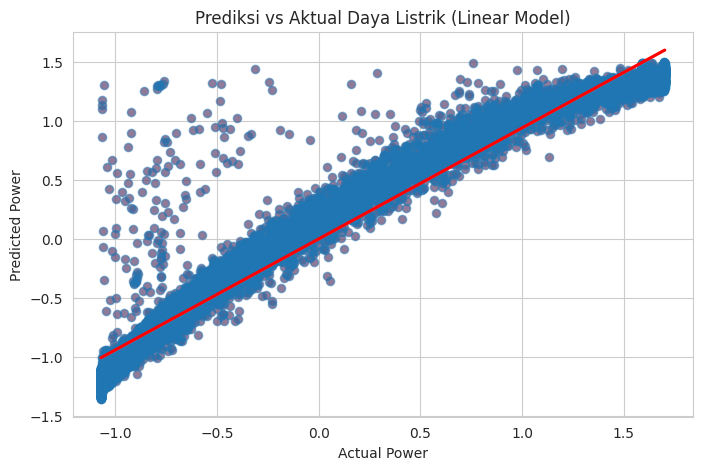

In [ ]:
#Plot Linear Model
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.5, color='red')
sns.regplot(x=y_test, y=y_pred_lin, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Linear Model)")
plt.show()

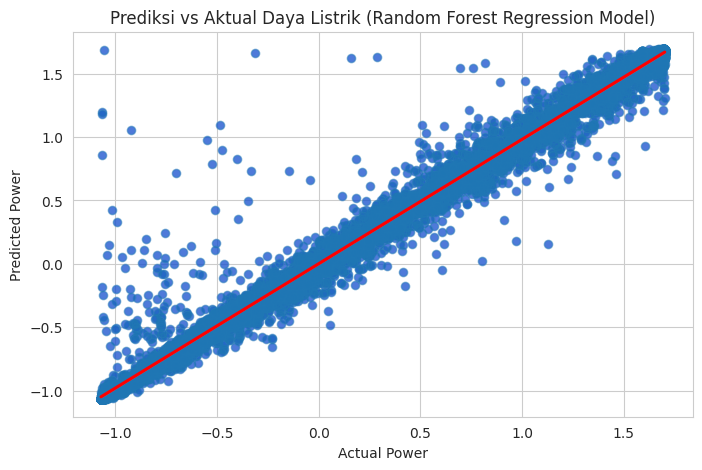

In [ ]:
#Plot untuk Random Forest Regressor
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Random Forest Regression Model)")
plt.show()

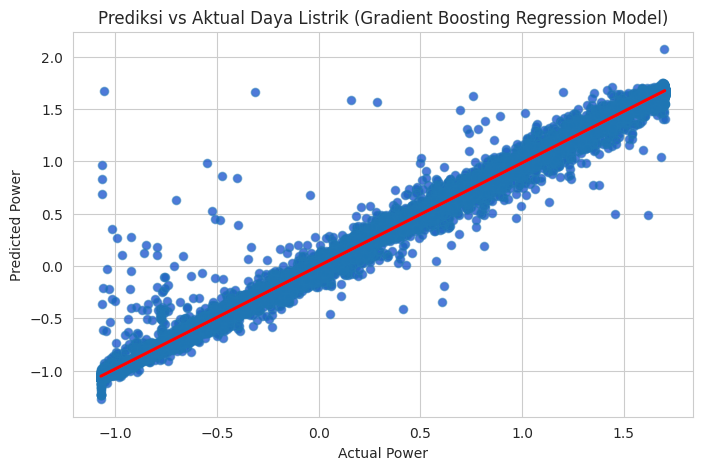

In [ ]:
#Plot untuk Gradient Boosting Regressor
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_rgb, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_rgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Gradient Boosting Regression Model)")
plt.show()

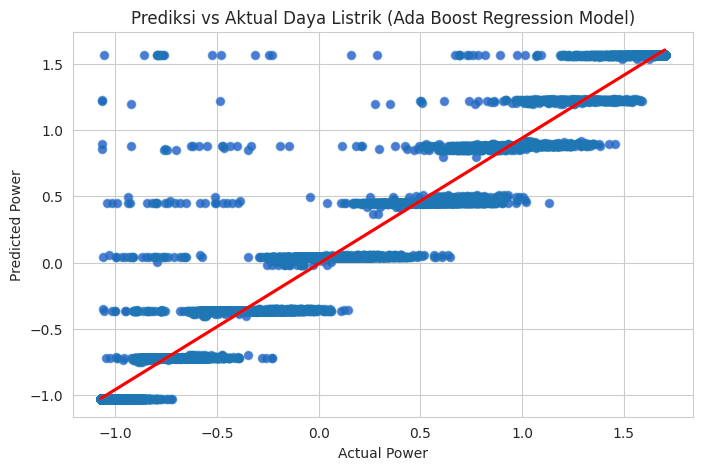

In [ ]:
#Plot untuk Ada Boost Regression
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_ada, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_ada, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Ada Boost Regression Model)")
plt.show()

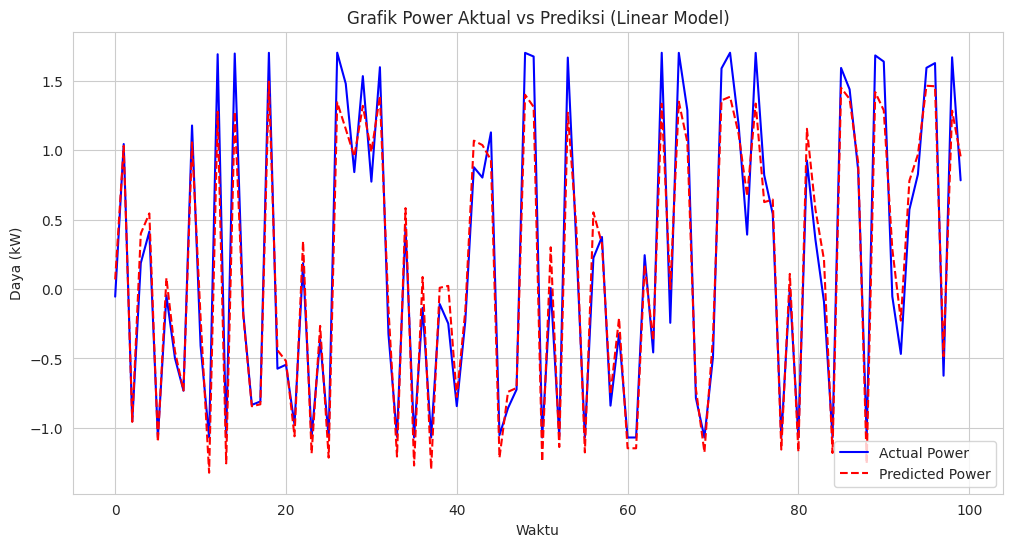

In [ ]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_lin[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Linear Model)")
plt.legend()
plt.show()


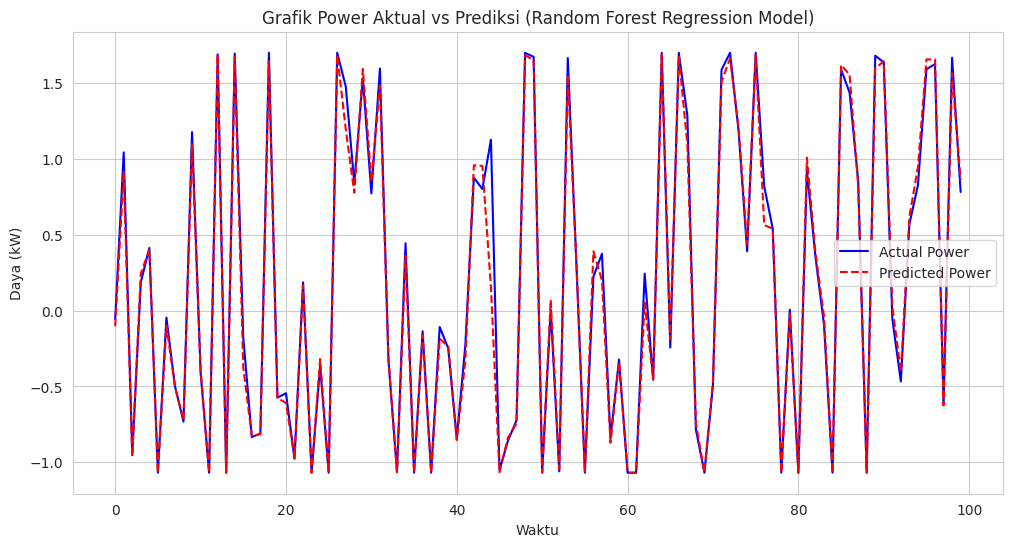

In [ ]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_rf[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Random Forest Regression Model)")
plt.legend()
plt.show()


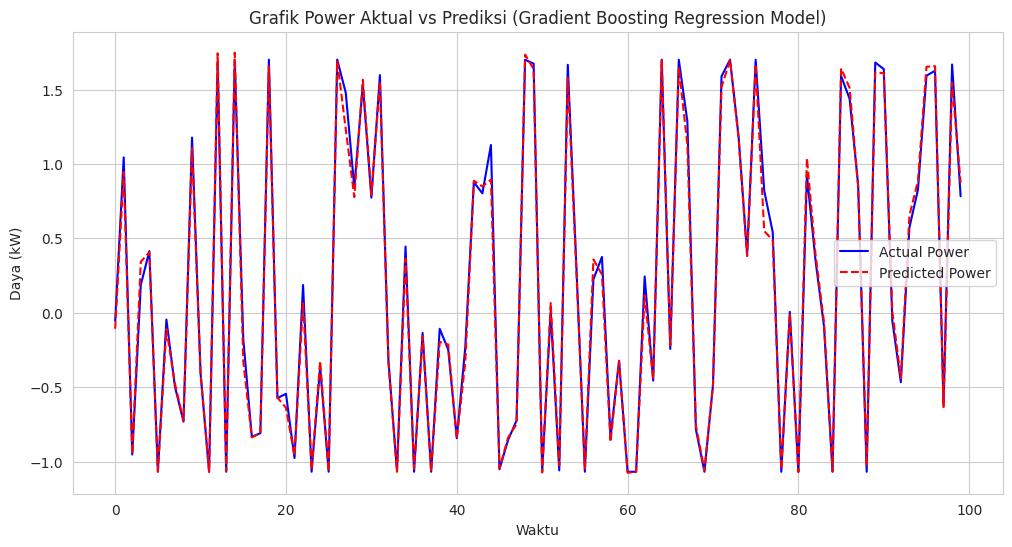

In [ ]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_rgb[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Gradient Boosting Regression Model)")
plt.legend()
plt.show()


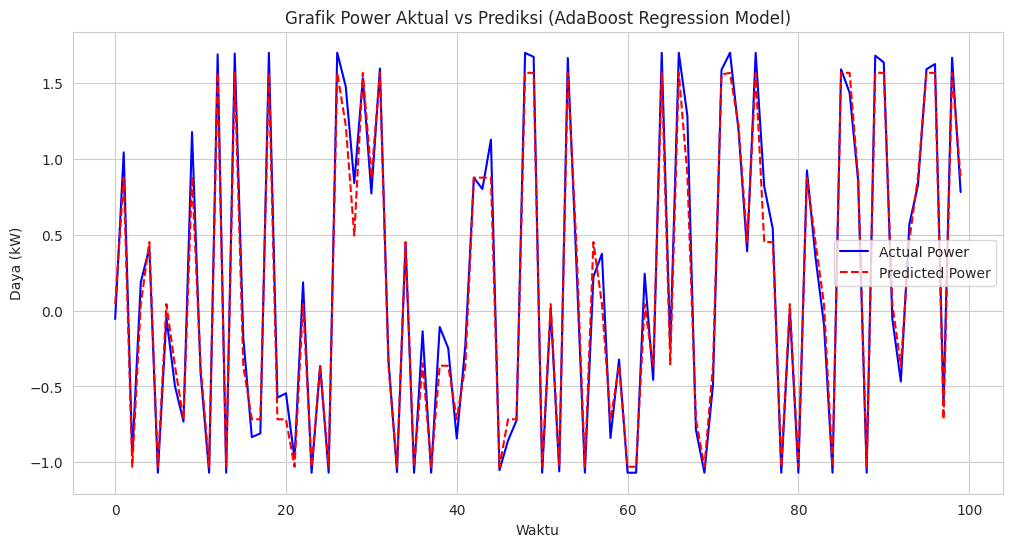

In [ ]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_ada[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (AdaBoost Regression Model)")
plt.legend()
plt.show()


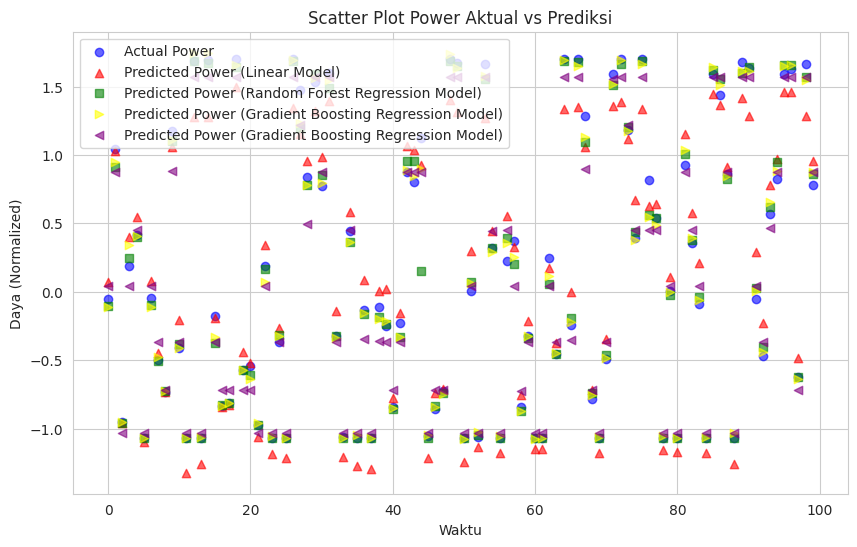

In [ ]:
#Scatter Plot untuk Prediksi
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="Actual Power", color='blue', marker='o', alpha=0.6)
plt.scatter(range(len(y_pred_lin[:100])), y_pred_lin[:100], label="Predicted Power (Linear Model)", color='red', marker='^', alpha=0.6) # Changed y_pred to y_pred_lin
plt.scatter(range(len(y_pred_rf[:100])), y_pred_rf[:100], label="Predicted Power (Random Forest Regression Model)", color='green', marker='s', alpha=0.6) # Changed y_pred to y_pred_rf
plt.scatter(range(len(y_pred_rgb[:100])), y_pred_rgb[:100], label="Predicted Power (Gradient Boosting Regression Model)", color='yellow', marker='>', alpha=0.6) # Changed y_pred to y_pred_rgb
plt.scatter(range(len(y_pred_ada[:100])), y_pred_ada[:100], label="Predicted Power (Gradient Boosting Regression Model)", color='purple', marker='<', alpha=0.6)
plt.xlabel("Waktu")
plt.ylabel("Daya (Normalized)")
plt.title("Scatter Plot Power Aktual vs Prediksi")
plt.legend()
plt.show()

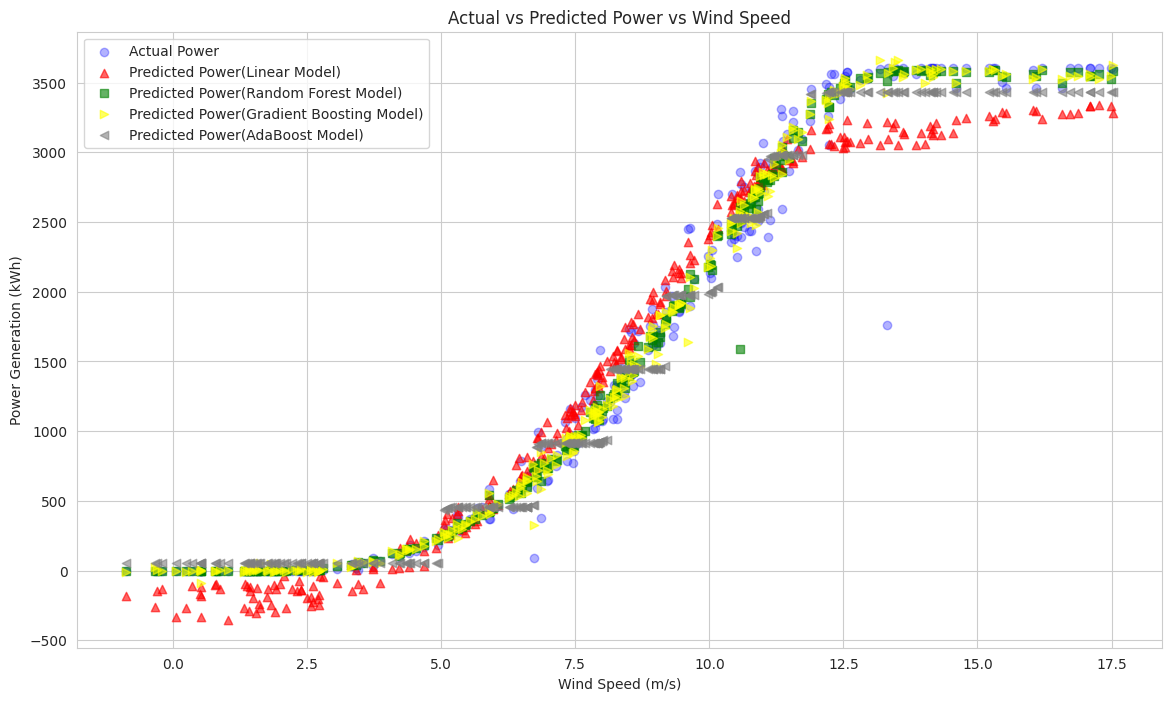

In [ ]:
#memplot hasil dari prediksi power dan wind speed setelah data di-denormalisasikan.
plt.figure(figsize=(14, 8))
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_test[:300].reshape(-1, 1)), label="Actual Power", color='blue',marker='o', alpha=0.3)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_lin[:300].reshape(-1, 1)), label="Predicted Power(Linear Model)", color='red',marker='^', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_rf[:300].reshape(-1, 1)), label="Predicted Power(Random Forest Model)",color='green',marker='s', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_rgb[:300].reshape(-1, 1)), label="Predicted Power(Gradient Boosting Model)",color='yellow',marker='>', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_ada[:300].reshape(-1, 1)), label="Predicted Power(AdaBoost Model)",color='grey',marker='<', alpha=0.6)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Generation (kWh)")
plt.title("Actual vs Predicted Power vs Wind Speed")
plt.legend()
plt.show()

In [ ]:
# Memilih Best Model dari nilai R-Square
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = [best_model_name]
best_model

['GradientBoostingRegressor']

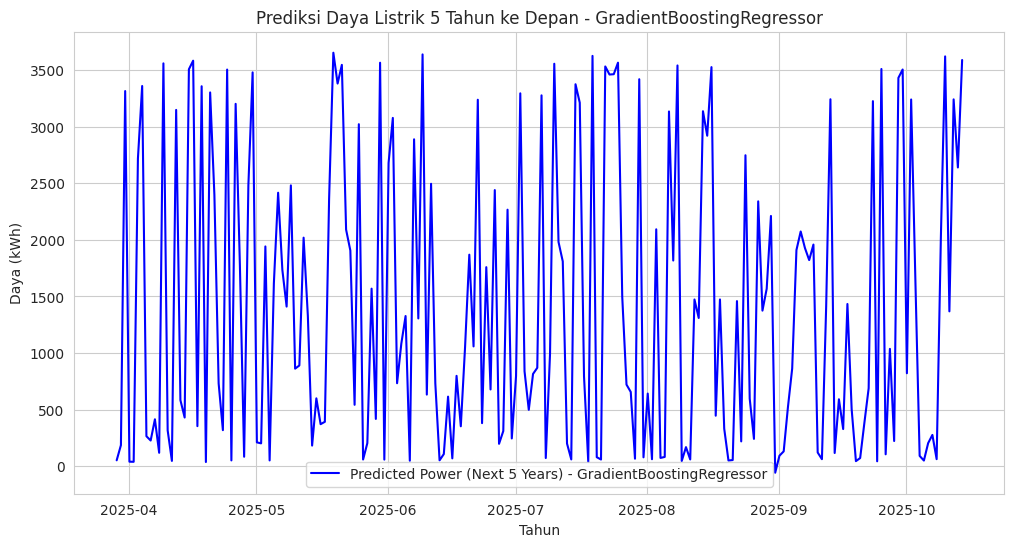

In [ ]:
# Prediksi Untuk 5 Tahun Kedepan
years_future = 5
dates_future = pd.date_range(start=pd.Timestamp.now(), periods=years_future*365*24//10, freq='D')
X_future = X.sample(len(dates_future), replace=True).reset_index(drop=True)
X_future = scaler_X.transform(X_future)
y_future = RGB.predict(X_future)
y_future = scaler_y.inverse_transform(y_future.reshape(-1, 1)).ravel()

# Visualisasi untuk hasil Prediksi menggunakan Gradient Boosting Regressor
plt.figure(figsize=(12, 6))
plt.plot(dates_future[:200], y_future[:200], label=f"Predicted Power (Next 5 Years) - {best_model_name}", color='blue') #menampilkan 200 data Pertama
plt.xlabel("Tahun")
plt.ylabel("Daya (kWh)")
plt.title(f"Prediksi Daya Listrik 5 Tahun ke Depan - {best_model_name}")
plt.legend()
plt.show()

#DATASET 2
DATASET 2 MENGGUNAKAN DATA BERASAL DARI https://zenodo.org/records/5516550#.YaR-0S9Q2X0.
DATA INI MENCAKUP KECEPATAN ANGIN PER JAM UNTUK SETIAP TURBIN YANG DIUKUR OLEH ANEMOMETER YANG DIPASANG PADA MASING-MASING TURBIN. SELAIN ITU, TERSEDIA DATA PENGUKURAN KECEPATAN DAN ARAH ANGIN PER JAM SELAMA SATU TAHUN.
ANALISIS AKAN DILAKUKAN PADA PENGARUH PENGUKURAN KECEPATAN ANGIN TERHADAP POWER YANG DIHASILKAN.

Mast_Speed merupakan data kecepatan angin yang diukur oleh anemometer pada turbin angin.
Mean Power adalah rata-rata daya yang dihasilkan oleh masing-masing turbin pada setiap waktu kemudian di rata-rata.
Pada seleksi machine learning, tidak seluruh data turbin digunakan, namun hanya data turbin yang memiliki korelasi tertinggi yang digunakan.

In [1]:
#Start Upload dan Reading Data
from google.colab import files

data_2 = files.upload()

Saving Wind Spatio-Temporal Dataset2.csv to Wind Spatio-Temporal Dataset2.csv


In [5]:
df=pd.read_csv("Wind Spatio-Temporal Dataset2.csv")
df.head(10)

Time  Turbine1_Speed  Turbine1_Power  Turbine2_Speed  \
0  9/1/2010 0:00             8.9        0.432136             8.9   
1  9/1/2010 1:00             9.5        0.518432             9.1   
2  9/1/2010 2:00            10.1        0.613067             9.6   
3  9/1/2010 3:00            11.3        0.753558            10.8   
4  9/1/2010 4:00            11.4        0.766006            10.9   
5  9/1/2010 5:00             9.6        0.532845             9.4   
6  9/1/2010 6:00             9.7        0.571318             9.7   
7  9/1/2010 7:00            12.1        0.845274            11.3   
8  9/1/2010 8:00            11.3        0.797511            11.3   
9  9/1/2010 9:00            10.7        0.691144            10.9   

   Turbine2_Power  Turbine3_Speed  Turbine3_Power  Turbine4_Speed  \
0        0.463000             7.7        0.329147             9.2   
1        0.493625             5.6        0.178624             9.4   
2        0.597653             7.0        0.284041             9.6   
3        0.725929             8.3        0.463791            10.8   
4        0.750894             8.3        0.446672            10.7   
5        0.542779             9.1        0.507546            10.0   
6        0.610522             9.6        0.569096             9.9   
7        0.811964             9.9        0.630139            11.3   
8        0.797367            10.6        0.736457            11.5   
9        0.746663            10.7        0.732008            11.4   

   Turbine4_Power  Turbine5_Speed  ...  Turbine199_Speed  Turbine199_Power  \
0        0.542983        2.700000  ...              10.2          0.568750   
1        0.570645        9.071853  ...              10.3          0.602928   
2        0.609634        8.791228  ...               9.9          0.542286   
3        0.750328        9.644845  ...              10.9          0.697297   
4        0.766901        9.662462  ...              11.3          0.724831   
5        0.659235        9.244940  ...              11.0          0.691948   
6        0.671814        9.071413  ...              10.3          0.619313   
7        0.841064        2.600000  ...              10.7          0.667568   
8        0.843329        9.678757  ...              11.1          0.715315   
9        0.831465        9.858891  ...              11.2          0.750619   

   Turbine200_Speed  Turbine200_Power  Mast1_Speed  Mast1_Direction  \
0              10.1          0.600381         7.58           182.00   
1               9.6          0.528297        11.06           189.80   
2               9.4          0.512570        11.82           186.30   
3              10.7          0.700643        10.98           188.50   
4              11.0          0.745145         9.25           197.20   
5              10.7          0.725009         8.30           321.90   
6               9.5          0.538663         7.55           315.70   
7              10.2          0.657333         8.20            63.56   
8              10.8          0.719111         7.73            95.80   
9              11.4          0.802157         3.32            80.80   

   Mast2_Speed  Mast2_Direction  Mast3_Speed  Mast3_Direction  
0         9.50           217.10         9.47           197.60  
1         9.81           213.40         9.68           197.40  
2         9.47           212.10         9.24           198.40  
3         8.86           217.40        10.01           199.90  
4         8.44           224.20         9.03           204.40  
5         8.98           235.40         7.98           218.00  
6         7.72           348.50         8.78           350.10  
7         6.99            14.28         6.27             9.01  
8         6.05            80.80         4.67            89.60  
9         1.28            99.50         2.16           137.90  

[10 rows x 407 columns]

In [15]:
#Mengubah Format Waktu
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

#Mengisi Missing Values dengan forward fill dan backward fill
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

<ipython-input-15-934132936a49>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
<ipython-input-15-934132936a49>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Columns: 408 entries, Time to Mean_Power
dtypes: datetime64[ns](1), float64(407)
memory usage: 27.3 MB


In [17]:
#Reduksi fitur turbin yang terlalu berkorelasi tinggi
correlation_matrix = df.corr(numeric_only=True)
power_columns = [col for col in df.columns if "Power" in col] #Memilih Power/daya yang dihasilkan turbin
df["Mean_Power"] = df[power_columns].mean(axis=1)
correlation_with_power = correlation_matrix["Mean_Power"].sort_values(ascending=False)
selected_turbines = correlation_with_power.index[1:11]  # 10 turbin dengan korelasi tertinggi

In [18]:
df['Mean_Power'] #Rata-rata Power/Daya yang dihasilkan setiap 1 jam (Semua turbin)

0       0.412840
1       0.518888
2       0.487449
3       0.609341
4       0.607927
          ...   
8755    0.041674
8756    0.048383
8757    0.070504
8758    0.062981
8759    0.050696
Name: Mean_Power, Length: 8760, dtype: float64

In [19]:
correlation_with_power

Mean_Power          1.000000
Turbine136_Power    0.966778
Turbine73_Power     0.964505
Turbine52_Power     0.964358
Turbine135_Power    0.963145
                      ...   
Mast2_Speed         0.562642
Mast3_Speed         0.560422
Mast1_Direction     0.187999
Mast2_Direction     0.163482
Mast3_Direction     0.139974
Name: Mean_Power, Length: 407, dtype: float64

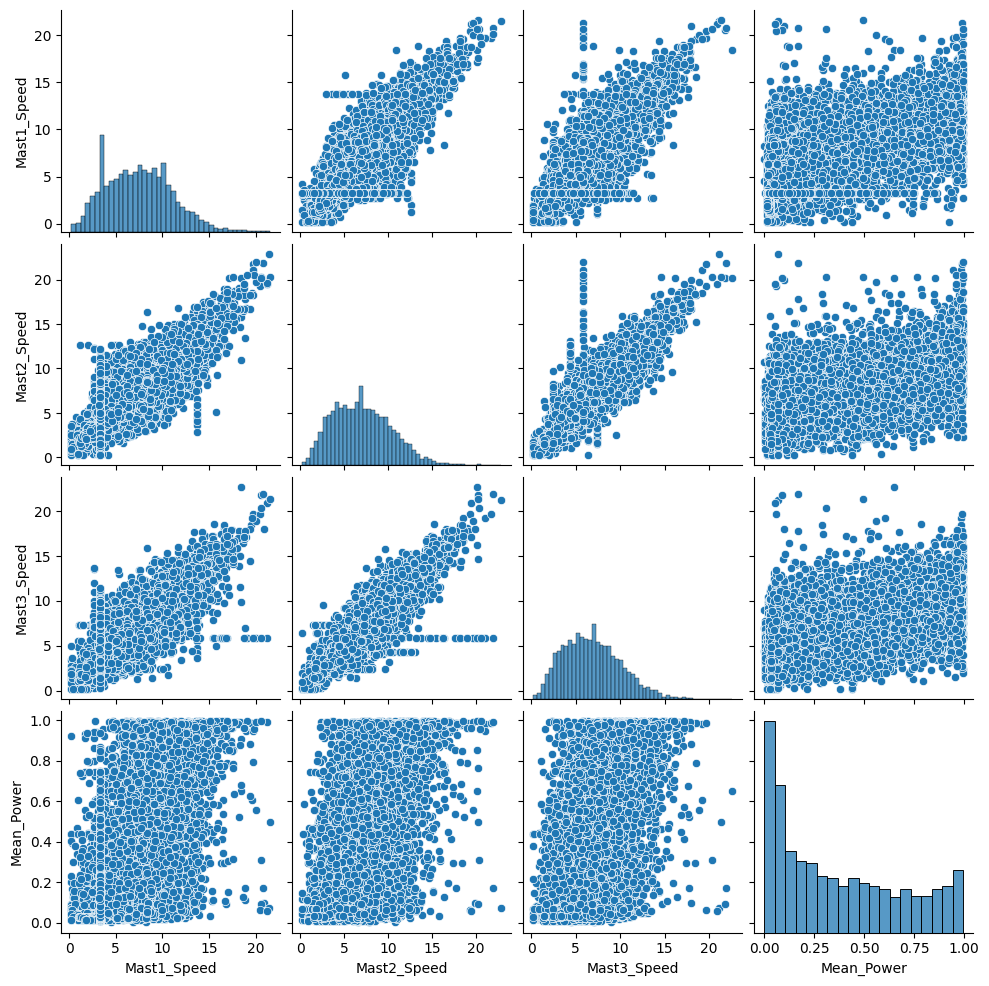

In [20]:
#Visuaslisasi data kecepatan angin dan Mean Power
sns.pairplot(df[["Mast1_Speed", "Mast2_Speed", "Mast3_Speed", "Mean_Power"]])
plt.show()

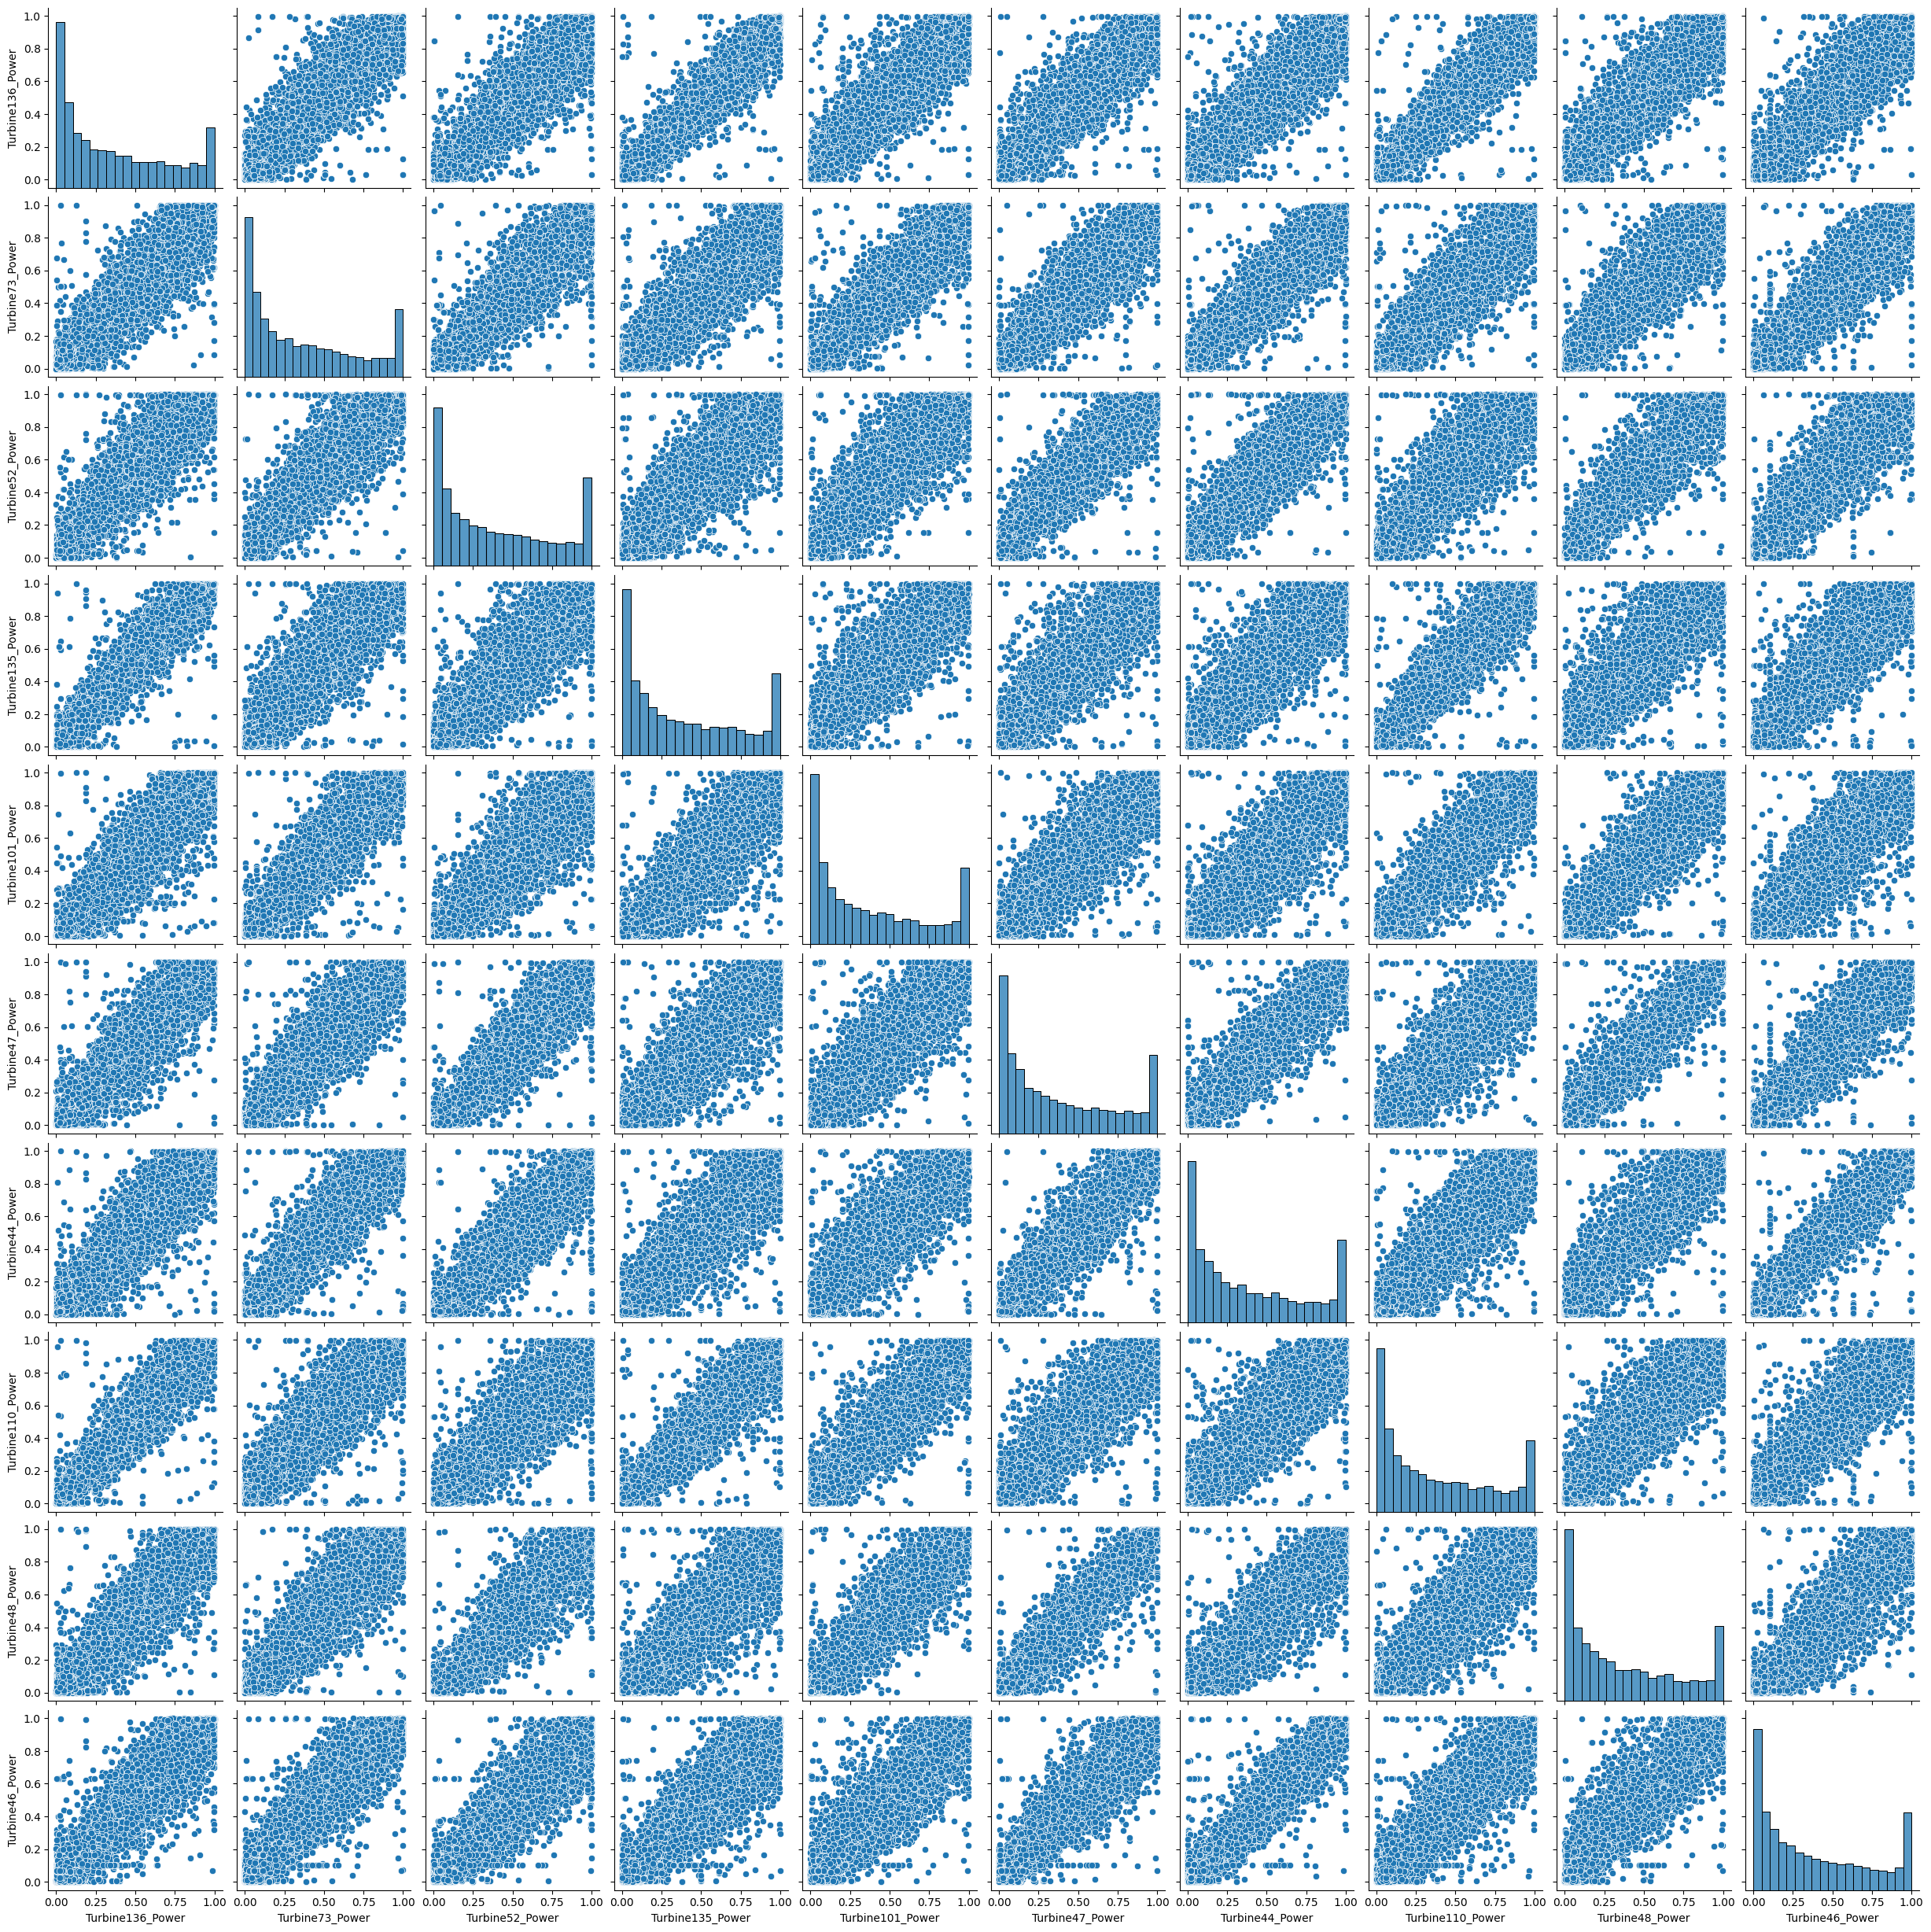

In [21]:
#Visualisasi data turbin yang dipilih
sns.pairplot(df[selected_turbines])

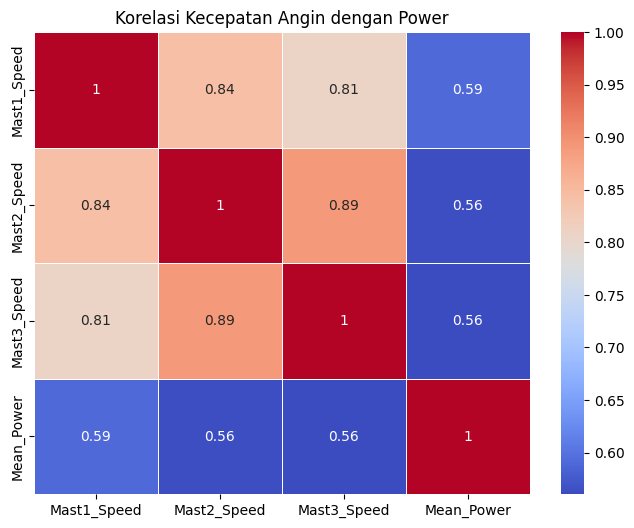

In [22]:
#Hitung korelasi antara kecepatan angin tiap Mast dengan Mean Power
wind_speed_features = ["Mast1_Speed", "Mast2_Speed", "Mast3_Speed"]
correlation = df[wind_speed_features + ["Mean_Power"]].corr()

#Visualisasi heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi Kecepatan Angin dengan Power")
plt.show()


In [23]:
#Memilih fitur yang akan digunakan
selected_features = list(selected_turbines) + ["Mast1_Speed", "Mast2_Speed", "Mast3_Speed", "Mean_Power"]
df_selected = df[selected_features]

In [24]:
#Transformasi arah angin menjadi komponen X dan Y
for i in range(1, 4):  # Untuk Mast1, Mast2, Mast3
    df_selected[f"Mast{i}_Wind_X"] = df[f"Mast{i}_Speed"] * np.cos(np.radians(df[f"Mast{i}_Direction"]))
    df_selected[f"Mast{i}_Wind_Y"] = df[f"Mast{i}_Speed"] * np.sin(np.radians(df[f"Mast{i}_Direction"]))

<ipython-input-24-5f8e6d142a61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[f"Mast{i}_Wind_X"] = df[f"Mast{i}_Speed"] * np.cos(np.radians(df[f"Mast{i}_Direction"]))
<ipython-input-24-5f8e6d142a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[f"Mast{i}_Wind_Y"] = df[f"Mast{i}_Speed"] * np.sin(np.radians(df[f"Mast{i}_Direction"]))
<ipython-input-24-5f8e6d142a61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [25]:
#Menghapus kolom kecepatan angin lama karena sudah terwakili dalam X dan Y
df_selected.drop(columns=["Mast1_Speed", "Mast2_Speed", "Mast3_Speed"], inplace=True)

<ipython-input-25-7be6104bf1c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=["Mast1_Speed", "Mast2_Speed", "Mast3_Speed"], inplace=True)


In [26]:
from sklearn.preprocessing import MinMaxScaler
#Normalisasi Data
scaler = MinMaxScaler()
features_to_scale = df_selected.columns.difference(["Mean_Power"])
df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])

<ipython-input-26-456bcc21a5d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])


In [27]:
#Pemodelan Machine Learning
X = df_selected.drop(columns=["Mean_Power"])
y = df_selected["Mean_Power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R² Score": r2}
    print(f"{name} - MSE: {mse:.4f}, R² Score: {r2:.4f}")

Linear Regression - MSE: 0.0012, R² Score: 0.9873
Random Forest - MSE: 0.0011, R² Score: 0.9883


In [28]:
results_df = pd.DataFrame(results).T
print(results_df)

                        MSE  R² Score
Linear Regression  0.001216  0.987333
Random Forest      0.001122  0.988313


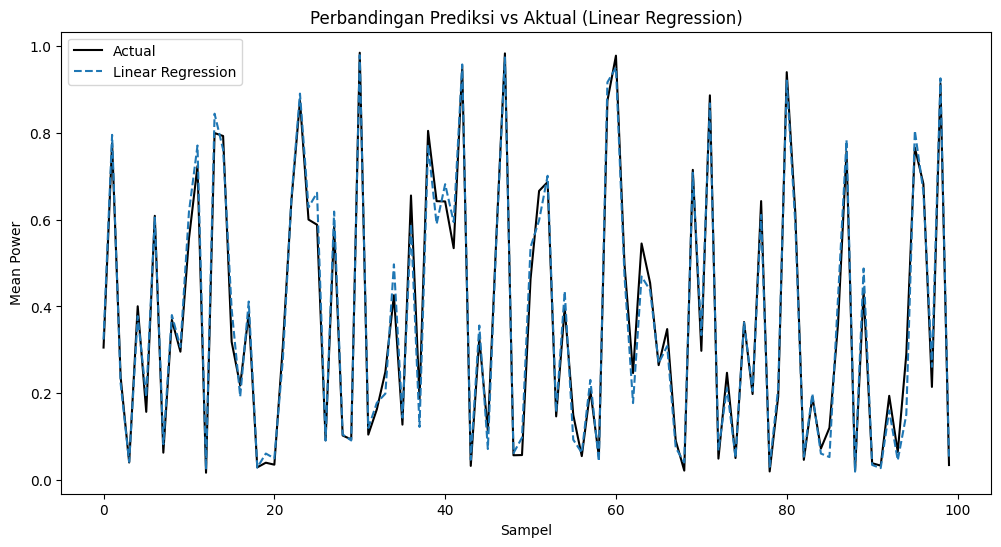

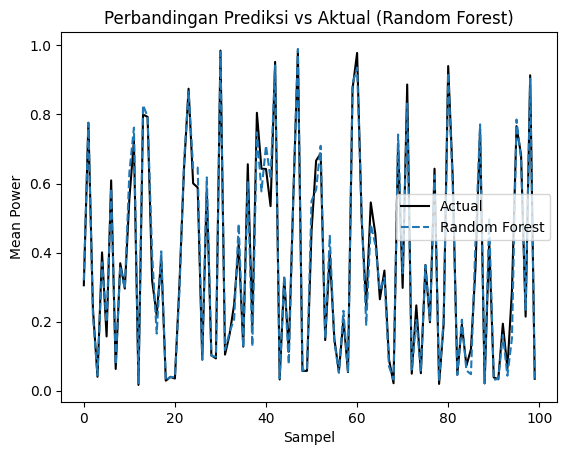

In [29]:
#Plot Hasil Prediksi
plt.figure(figsize=(12, 6))
for name, y_pred in predictions.items():
    plt.plot(y_test.values[:100], label="Actual", color='black')
    plt.plot(y_pred[:100], label=name, linestyle='dashed')
    plt.title(f"Perbandingan Prediksi vs Aktual ({name})")
    plt.xlabel("Sampel")
    plt.ylabel("Mean Power")
    plt.legend()
    plt.show()